# Training by using the derivative of multihead coherent state generation by pullback

Use the multihead (2-head) gates in the phase space 
to create a network that represent a coherent state,
by starting from a Gaussian state and making a pullback

Use the derivative for the training

NOTE: remember to shut down the kernel when out of memory

<img src="../img/complexcoherentDER.png" width="800" height="200" />

<img src="../img/logo_circular.png" width="20" height="20" />@by claudio<br>

nonlinearxwaves@gmail.com<br>
@created 28 july 2020<br>
@version 15 may 2023

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warning messages

In [2]:
import numpy as np
from thqml import phasespace as ps
from thqml.utilities import utilities
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
tf_complex = tf.complex
tf_real = tf.float32
np_complex = complex
np_real = np.float32

Precision for output on the screen

In [4]:
np.set_printoptions(precision=2)

## Dimension

In [5]:
N = 10

## Build vacuum by the Gaussian state

In [6]:
vacuum = ps.VacuumLayer(N, name='Vacuum')

## Build the pullback layer for generating the input coherent state

### Target displacement vector (IMPORTANT THE DISPLACEMENT VECTOR MUST BE NORMALIZED!!!)
The displacement vector is a normalized column vector

In [7]:
dinput = 3.0*np.ones((N,1)); 
norm = np.linalg.norm(dinput)
dinput = dinput /norm
print(dinput.transpose())

[[0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32 0.32]]


Check the normalization of the dtarget

In [8]:
print(np.dot(dinput.transpose(), dinput)) 

[[1.]]


### Symplectic operator
A simple identity matrix

In [9]:
M = np.eye(N)

### Build the linear layer
The layer is a constant layer, as no training is needed

In [10]:
D = ps.DisplacementLayerConstant(dinput, name='Glauber')

## Define the layer for the complex medium
The LinearConstantMultiHead generate by default a random medium with 
the relevant symplectic operator

In [11]:
R = ps.RandomLayerConstant(N, name='RandomConstant')

## Define the trainable unitary layer

In [12]:
T = ps.RandomLayer(N, name='Trainable')

## Define the normalize target displacement vector

In [13]:
dtarget = np.zeros((N,1)); dtarget[0]=1.0; 
norm = np.linalg.norm(dtarget)
dtarget = dtarget /norm
print(dtarget.transpose())

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Check the normalization

In [14]:
print(np.dot(dtarget.transpose(), dtarget)) 

[[1.]]


## Connect the layers

Input layer

In [15]:
xin = tf.keras.layers.Input(N)
x3, a3 = R(xin)
x2, a2 = T(x3,a3)
x1, a1 = D(x2,a2)
chir, chii = vacuum(x1, a1) 
pullback = tf.keras.Model(inputs = xin, outputs=[chir, chii])

Add the derivative layer for evaluating the mean <R>

In [16]:
der_layer = ps.meanRLayer(N, name='meanR')
chii_x = der_layer(chir, chii, pullback)


In [17]:
pullback_der = tf.keras.Model(inputs = xin, outputs=chii_x)

### Store the M,d of the random R layer for later chek

In [18]:
M_R_tf, _=R.get_M(); M_R=M_R_tf.numpy()

In [19]:
d_R=R.d.numpy()

### Store the M, d of the untrained U_train layer for later check

In [20]:
WR_untrained_T = T.WR.numpy()

In [21]:
WI_untrained_T = T.WI.numpy()

In [22]:
M_untrained_T, MI_untrained_T = T.get_M()

### Auxiliary staff

In [23]:
x0 = tf.constant(np.zeros((1,N)))
with tf.GradientTape() as tape:
    tape.watch(x0)
    cr, ci = pullback(x0)
    chii_x = tape.gradient(ci, x0)

In [24]:
@tf.function
def derivative(yr):
    x = tf.constant(np.zeros((1,N)))
    with tf.GradientTape() as tape:
        tape.watch(x)
        cr, ci = pullback(x)
        chii_x = tape.gradient(ci, x)
    return chii_x

## Build the training, and train by the targed expected value

Number of training points
Also a single training point is enough for Gaussian state, more points improve the training

In [25]:
Nbatch = 1

Define the numpy function for the target characteristic function:
    a coherent state with a target mean observable
One need a target R (shape (Nbatch,N)) for any training point

Remark: d has shape (N,1) and R has shape (1,N)

In [26]:
xtrain = np.random.rand(Nbatch, N)-0.5
Rtrain = np.zeros((Nbatch,N))
for j in range(Nbatch):
    for i in range(N):
        Rtrain[j,i]=dtarget[i]

## Train the model

In [27]:
pullback_der.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                loss='mean_squared_error')

Summary of the derivative model

In [28]:
pullback_der.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 RandomConstant (RandomLayer)   [(None, 10),         50          ['input_1[0][0]']                
                                 (10, 1)]                                                         
                                                                                                  
 Trainable (RandomLayer)        [(None, 10),         50          ['RandomConstant[0][0]',         
                                 (10, 1)]                         'RandomConstant[0][1]']         
                                                                                            

Test the call of the derivative layer

In [29]:
pullback_der(xtrain)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 0.15, -0.33, -0.02, -0.4 ,  0.15, -0.46,  0.08, -0.21,  0.26,
        -0.59]], dtype=float32)>

## Training of the model

In [30]:
history = pullback_der.fit(x=xtrain,
                      y=Rtrain,
                      epochs=200,
                      verbose=1)

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.1695
Epoch 2/200
1/1 [==============================] - 0s 6ms/step - loss: 0.1605
Epoch 3/200
1/1 [==============================] - 0s 5ms/step - loss: 0.1517
Epoch 4/200
1/1 [==============================] - 0s 5ms/step - loss: 0.1432
Epoch 5/200
1/1 [==============================] - 0s 6ms/step - loss: 0.1349
Epoch 6/200
1/1 [==============================] - 0s 5ms/step - loss: 0.1270
Epoch 7/200
1/1 [==============================] - 0s 7ms/step - loss: 0.1194
Epoch 8/200
1/1 [==============================] - 0s 6ms/step - loss: 0.1122
Epoch 9/200
1/1 [==============================] - 0s 7ms/step - loss: 0.1054
Epoch 10/200
1/1 [==============================] - 0s 4ms/step - loss: 0.0991
Epoch 11/200
1/1 [==============================] - 0s 5ms/step - loss: 0.0932
Epoch 12/200
1/1 [==============================] - 0s 6ms/step - loss: 0.0877
Epoch 13/200
1/1 [==============================] - 0s 5ms/ste

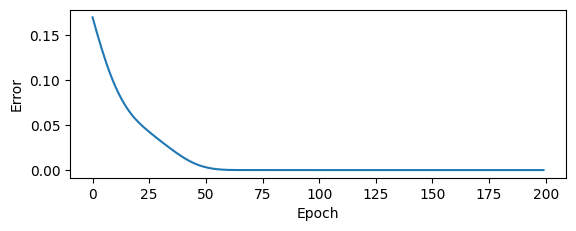

In [31]:
# %%
# %matplotlib inline
# Plot training & validation accuracy values
f1 = plt.figure
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.savefig('training_DER.pdf', bbox_inches='tight')

## Test the derivative of the model
Evaluate the expectation value of the displacement as derivative of the characterisc function

In [32]:
x = tf.Variable(np.zeros((1,N)), dtype=tf_real) # the derivative are evaluated at x=0
with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    chir, chii = pullback(x)

In [33]:
print(tape.gradient(chir,x))

tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 10), dtype=float32)


In [34]:
print(tape.gradient(chii,x))

tf.Tensor(
[[ 1.00e+00  1.30e-05 -1.59e-05 -5.30e-05  3.69e-05 -1.02e-05  1.66e-05
   3.37e-06  8.47e-06  1.68e-05]], shape=(1, 10), dtype=float32)


Use the derivative function for the derivative

In [35]:
print(derivative(x))

tf.Tensor(
[[ 1.00e+00  1.29e-05 -1.59e-05 -5.31e-05  3.68e-05 -1.03e-05  1.66e-05
   3.42e-06  8.46e-06  1.67e-05]], shape=(1, 10), dtype=float64)


Use the derivative model

In [36]:
pullback_der(xtrain)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 1.00e+00,  1.30e-05, -1.59e-05, -5.30e-05,  3.69e-05, -1.02e-05,
         1.66e-05,  3.37e-06,  8.47e-06,  1.68e-05]], dtype=float32)>

## Plot the model

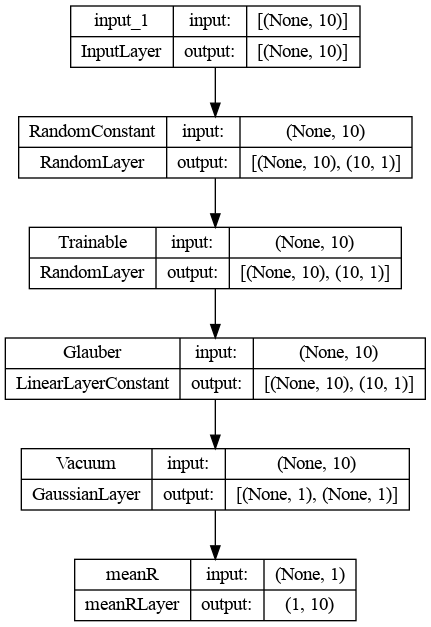

In [37]:
dot_img_file = 'pullback_DER.png'
#
tf.keras.utils.plot_model(pullback_der, to_file=dot_img_file, show_shapes=True)

## Check the weights of the layers

### d and M of the complex layer LL_complex (these are unchanged)

In [38]:
print(R.d.numpy().transpose())

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [39]:
print(d_R.transpose())

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [40]:
print(M_R)

[[ 2.58e-01  4.84e-01  2.29e-01 -2.14e-01  5.82e-02  5.90e-01 -2.39e-01
  -1.21e-01  3.67e-01 -2.07e-01]
 [-4.84e-01  2.58e-01  2.14e-01  2.29e-01 -5.90e-01  5.82e-02  1.21e-01
  -2.39e-01  2.07e-01  3.67e-01]
 [-9.68e-03 -3.83e-01  4.56e-01  5.26e-02  2.51e-01  7.29e-02 -1.25e-01
   4.39e-01  4.13e-01  4.42e-01]
 [ 3.83e-01 -9.68e-03 -5.26e-02  4.56e-01 -7.29e-02  2.51e-01 -4.39e-01
  -1.25e-01 -4.42e-01  4.13e-01]
 [-1.91e-01  4.49e-01  4.07e-01  3.19e-01  5.86e-01 -1.29e-01  2.33e-01
  -5.89e-02 -2.79e-01  2.46e-04]
 [-4.49e-01 -1.91e-01 -3.19e-01  4.07e-01  1.29e-01  5.86e-01  5.89e-02
   2.33e-01 -2.46e-04 -2.79e-01]
 [ 4.80e-01 -2.09e-02  2.78e-01  3.66e-01 -3.75e-01  2.49e-02  4.77e-01
   3.13e-01 -5.94e-03 -3.00e-01]
 [ 2.09e-02  4.80e-01 -3.66e-01  2.78e-01 -2.49e-02 -3.75e-01 -3.13e-01
   4.77e-01  3.00e-01 -5.94e-03]
 [ 2.80e-01  7.55e-02 -4.55e-01  6.97e-02  2.54e-01  1.21e-01  5.41e-01
  -2.10e-01  3.19e-01  4.31e-01]
 [-7.55e-02  2.80e-01 -6.97e-02 -4.55e-01 -1.21e-01  2.

In [41]:
M_R_final, _=R.get_M();print(M_R_final)

tf.Tensor(
[[ 2.58e-01  4.84e-01  2.29e-01 -2.14e-01  5.82e-02  5.90e-01 -2.39e-01
  -1.21e-01  3.67e-01 -2.07e-01]
 [-4.84e-01  2.58e-01  2.14e-01  2.29e-01 -5.90e-01  5.82e-02  1.21e-01
  -2.39e-01  2.07e-01  3.67e-01]
 [-9.68e-03 -3.83e-01  4.56e-01  5.26e-02  2.51e-01  7.29e-02 -1.25e-01
   4.39e-01  4.13e-01  4.42e-01]
 [ 3.83e-01 -9.68e-03 -5.26e-02  4.56e-01 -7.29e-02  2.51e-01 -4.39e-01
  -1.25e-01 -4.42e-01  4.13e-01]
 [-1.91e-01  4.49e-01  4.07e-01  3.19e-01  5.86e-01 -1.29e-01  2.33e-01
  -5.89e-02 -2.79e-01  2.46e-04]
 [-4.49e-01 -1.91e-01 -3.19e-01  4.07e-01  1.29e-01  5.86e-01  5.89e-02
   2.33e-01 -2.46e-04 -2.79e-01]
 [ 4.80e-01 -2.09e-02  2.78e-01  3.66e-01 -3.75e-01  2.49e-02  4.77e-01
   3.13e-01 -5.94e-03 -3.00e-01]
 [ 2.09e-02  4.80e-01 -3.66e-01  2.78e-01 -2.49e-02 -3.75e-01 -3.13e-01
   4.77e-01  3.00e-01 -5.94e-03]
 [ 2.80e-01  7.55e-02 -4.55e-01  6.97e-02  2.54e-01  1.21e-01  5.41e-01
  -2.10e-01  3.19e-01  4.31e-01]
 [-7.55e-02  2.80e-01 -6.97e-02 -4.55e-01 -1

### d and M of the trained layer, before and after training (they must change)

In [42]:
T.WR

<tf.Variable 'Trainable/WR:0' shape=(5, 5) dtype=float32, numpy=
array([[ 0.85, -0.32,  0.51, -0.43, -0.18],
       [ 0.13,  0.97,  0.31,  0.38,  0.57],
       [ 1.09,  0.2 ,  0.53,  0.45,  0.23],
       [ 0.23,  0.26,  0.48,  0.5 ,  0.47],
       [-0.22,  0.44, -0.08,  0.66,  1.07]], dtype=float32)>

In [43]:
WR_untrained_T

array([[0.59, 0.21, 0.11, 0.01, 0.11],
       [0.66, 0.87, 0.39, 0.34, 0.42],
       [0.7 , 0.28, 0.13, 0.87, 0.32],
       [0.67, 0.22, 0.9 , 0.93, 0.46],
       [0.06, 0.29, 0.  , 0.65, 0.88]], dtype=float32)

In [44]:
T.WI

<tf.Variable 'Trainable/WI:0' shape=(5, 5) dtype=float32, numpy=
array([[ 0.3 ,  1.29,  0.84,  0.66,  1.46],
       [ 0.03,  0.39,  0.03,  0.42,  0.77],
       [ 0.07,  0.09,  0.81,  0.71,  0.92],
       [ 0.16,  0.18,  0.79,  0.89,  0.67],
       [-0.11,  0.87,  0.18,  0.8 ,  0.69]], dtype=float32)>

In [45]:
WI_untrained_T

array([[0.3 , 0.83, 0.73, 0.42, 1.  ],
       [0.48, 0.39, 0.1 , 0.35, 0.73],
       [0.18, 0.01, 0.81, 0.89, 0.32],
       [0.4 , 0.26, 0.61, 0.89, 0.68],
       [0.36, 0.91, 0.78, 0.79, 0.69]], dtype=float32)

In [46]:
M_T, _= T.get_M(); print(M_T)

tf.Tensor(
[[ 0.62  0.32  0.14 -0.05 -0.17 -0.5   0.15 -0.07  0.43 -0.06]
 [-0.32  0.62  0.05  0.14  0.5  -0.17  0.07  0.15  0.06  0.43]
 [-0.06  0.17  0.39 -0.49 -0.36  0.35 -0.15  0.45  0.22  0.21]
 [-0.17 -0.06  0.49  0.39 -0.35 -0.36 -0.45 -0.15 -0.21  0.22]
 [-0.17 -0.28  0.39 -0.25  0.24  0.1   0.19 -0.62  0.37  0.21]
 [ 0.28 -0.17  0.25  0.39 -0.1   0.24  0.62  0.19 -0.21  0.37]
 [-0.5   0.35 -0.03  0.01 -0.51 -0.04  0.49 -0.22 -0.03 -0.29]
 [-0.35 -0.5  -0.01 -0.03  0.04 -0.51  0.22  0.49  0.29 -0.03]
 [-0.09  0.02 -0.08  0.61 -0.06  0.37 -0.17  0.05  0.65 -0.14]
 [-0.02 -0.09 -0.61 -0.08 -0.37 -0.06 -0.05 -0.17  0.14  0.65]], shape=(10, 10), dtype=float32)


In [47]:
print(M_untrained_T)

tf.Tensor(
[[ 0.42 -0.22 -0.21  0.17 -0.13 -0.2   0.34  0.34  0.03  0.64]
 [ 0.22  0.42 -0.17 -0.21  0.2  -0.13 -0.34  0.34 -0.64  0.03]
 [-0.39 -0.1   0.31 -0.45 -0.03  0.38  0.11  0.58  0.03  0.19]
 [ 0.1  -0.39  0.45  0.31 -0.38 -0.03 -0.58  0.11 -0.19  0.03]
 [ 0.03  0.15 -0.08  0.15  0.3   0.58 -0.37 -0.27  0.13  0.54]
 [-0.15  0.03 -0.15 -0.08 -0.58  0.3   0.27 -0.37 -0.54  0.13]
 [-0.58  0.29  0.09  0.66  0.11 -0.16  0.16  0.18 -0.16  0.13]
 [-0.29 -0.58 -0.66  0.09  0.16  0.11 -0.18  0.16 -0.13 -0.16]
 [ 0.32  0.27 -0.16  0.35 -0.27  0.51  0.08  0.37  0.17 -0.41]
 [-0.27  0.32 -0.35 -0.16 -0.51 -0.27 -0.37  0.08  0.41  0.17]], shape=(10, 10), dtype=float32)


# Retrieve the covariance matrix

In [48]:
print(ps.covariance(N)(chir, chii, pullback))

(<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[ 1.00e+00,  9.35e-08, -2.61e-08,  1.11e-07, -1.23e-07,  3.12e-08,
        -6.14e-08,  1.39e-07, -1.14e-07,  3.82e-07],
       [-9.41e-08,  1.00e+00,  6.78e-08, -3.02e-08,  6.78e-08, -8.77e-08,
        -1.70e-07, -4.11e-08, -8.91e-08, -1.68e-09],
       [ 1.52e-08,  5.79e-08,  1.00e+00, -3.05e-08, -6.89e-08,  1.17e-08,
         2.98e-07,  6.46e-08, -1.47e-07,  1.40e-09],
       [ 4.14e-08, -5.74e-08,  1.49e-08,  1.00e+00,  1.20e-08, -5.17e-08,
        -5.44e-08,  3.02e-07,  1.05e-08, -1.57e-07],
       [-7.23e-08,  7.55e-08, -1.45e-07, -8.89e-08,  1.00e+00, -4.60e-08,
         1.55e-07,  1.44e-07,  1.42e-07, -8.95e-08],
       [ 3.71e-08, -1.03e-07,  1.75e-08, -3.76e-08,  1.30e-08,  1.00e+00,
        -1.63e-07,  1.25e-07,  1.31e-07,  1.19e-07],
       [ 4.01e-08, -1.05e-07,  2.93e-07, -2.42e-08,  1.61e-07, -1.12e-07,
         1.00e+00, -2.30e-08,  9.39e-09, -2.01e-08],
       [ 8.28e-08,  8.18e-09,  4.90e-08,  2.76e-07,  1.25e-0